
# Tarea N°02
## Instrucciones
1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.

**Nombre**: Jacson Aravena Perez

**Rol**: 201510506-5

2.- Debes pushear este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:

- Soluciones
- Código
- Que Binder esté bien configurado.
- Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 64 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [6]:
digits.select_dtypes(include=[np.number]).max()

c00        0
c01        8
c02       16
c03       16
c04       16
          ..
c60       16
c61       16
c62       16
c63       16
target     9
Length: 65, dtype: int32

### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

## Respuesta:

Se revisará en primer lugar, cuántos elementos distintos tenemos en target

In [7]:
digits.target.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

De lo anterior se desprende que queremos clasificar 10 tipos de elementos. En este caso los números del 0 al 9.

In [8]:
num_val=[len(digits[digits['target']==i].target) for i in range(10)]
print('el total de datos es:',sum(num_val))
print('el máximo es:', max(num_val))
print('el minimo es:', min(num_val))
print('el primedio es:', sum(num_val)/10)

el total de datos es: 1797
el máximo es: 183
el minimo es: 174
el primedio es: 179.7


<AxesSubplot:xlabel='target', ylabel='Count'>

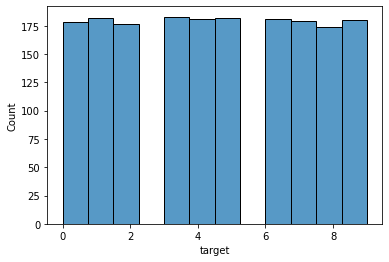

In [9]:
sns.histplot(digits.target)

Tenemos que la distribución es aproximadamente uniforme y vemos además que tenemos en promedio 179 datos por cada elemento a clasificar siendo 174 el menor número y 183 el mayor.

De la información sobre el conjunto de datos, se sabe que cada dato corresponde a una matriz de $8\times8$ con entradas de 0 a 16. Cada dato proviene de una matriz de $32\times32$ que ha pasado por un método de reducción de dimensiones que reduce la varianza. Cada dato corresponde a una imagen de un manuscrito de un número entre 0 y 9.
De aqui se desprende que para cada dato se están utilizando $8\times 8=64$ bits para la imagen $+$ $1$ bit para guardar la información del target correspondiente, con un total de 1797 datos se tiene en total $65\times 1797 = 116805 $ bits en total para el conjunto de datos.
Se aprecia una reducción considerable en el uso de memoria al aplicar la reducción dimensional comentada antes, pues se requerirían $ 1024 \times 1797 = 1840128 $ bits, un equivalente a 15 veces lo utilizado ahora. 

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

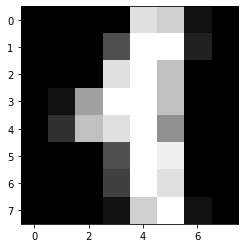

In [10]:
plt.imshow(digits_dict["images"][11], cmap='gray' )

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

## Respuesta:

<Figure size 432x288 with 0 Axes>

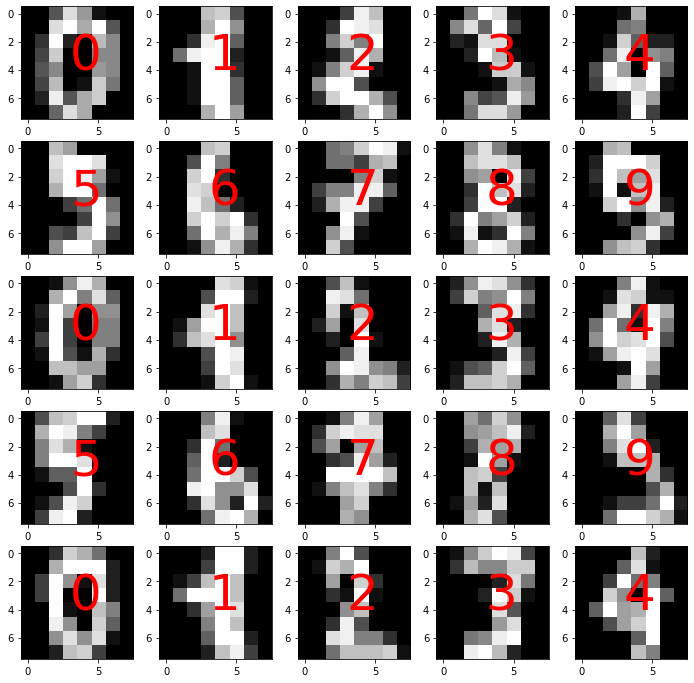

In [11]:
nx, ny = 5, 5
plt.figure()
fig, ax = plt.subplots(nx, ny, figsize=(12, 12))

for j in range(5):
    for i in range(5):
        ax[j,i].text(3 , 4 , str( (5*j + i)%10 ),fontsize=50, color='r')
        ax[j,i].imshow(digits_dict["images"][5*j + i], cmap='gray' )
        

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [12]:
X = digits.drop(columns="target").values
y = digits["target"].values

## Respuesta:

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
print('el conjunto de entrenamiento tiene:', len(y_train) , 'datos')
print('el conjunto de prueba tiene:',len(y_test) ,'datos')

el conjunto de entrenamiento tiene: 1437 datos
el conjunto de prueba tiene: 360 datos


### Regresión Logística

In [16]:
from metrics_classification import *
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [17]:
rlog = LogisticRegression(max_iter=4500)
rlog.fit(X_train,y_train)

LogisticRegression(max_iter=4500)

In [18]:
print('Con los conjuntos de entrenamiento y prueba seleccionados, el modelo identifica:', sum(y_test==rlog.predict(X_test)), 'números correctamente, de un total de:', len(y_test),'.')

Con los conjuntos de entrenamiento y prueba seleccionados, el modelo identifica: 350 números correctamente, de un total de: 360 .


In [19]:
df_metrics = summary_metrics( pd.DataFrame( { 'y':y_test,
                                              'yhat':rlog.predict(X_test) } ) )
confusion_matrix(list(y_test),list(rlog.predict(X_test)))

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 33,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 44,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 29,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1, 38]], dtype=int64)

Al observar la matriz de confusión, se puede apreciar que el modelo con los conjuntos de entrenamiento y prueba seleccionados, tiene 7 falsos positivos y 3 falsos negativos.

In [20]:
df_metrics

,accuracy,recall,precision,fscore
0,0.9722,0.9744,0.9736,0.9739


### K-NearestNeighbors

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import preprocessing

In [22]:
clf = neighbors.KNeighborsClassifier()
clf.fit(X_train,y_train)

KNeighborsClassifier()

In [23]:
print('Con los conjuntos de entrenamiento y prueba seleccionados, el modelo identifica:', sum(y_test==clf.predict(X_test)), 'números correctamente, de un total de:', len(y_test),'.')

Con los conjuntos de entrenamiento y prueba seleccionados, el modelo identifica: 355 números correctamente, de un total de: 360 .


In [24]:
df_metrics = summary_metrics( pd.DataFrame( { 'y':y_test,
                                              'yhat':clf.predict(X_test) } ) )
confusion_matrix(list(y_test),list(clf.predict(X_test)))

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 34,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 45,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  1,  1,  0,  0,  0, 38]], dtype=int64)

En este caso, podemos apreciar en la matriz que hay 3 falsos negativos y 2 falsos positivos.

In [25]:
df_metrics

,accuracy,recall,precision,fscore
0,0.9861,0.9878,0.9879,0.9878


### Modelo Arbol de Decisión

Se aplicará el modelo del árbol con una profundidad de 5 y luego se comparará con el clasificador encontrado después de ajustar los hiperparámetros con GridSearchCV.

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc = dtc.fit(X_train, y_train)

In [28]:
print('Con los conjuntos de entrenamiento y prueba seleccionados, el modelo identifica:', sum(y_test==dtc.predict(X_test)), 'números correctamente, de un total de:', len(y_test),'.')

Con los conjuntos de entrenamiento y prueba seleccionados, el modelo identifica: 308 números correctamente, de un total de: 360 .


In [29]:
df_metrics = summary_metrics( pd.DataFrame( { 'y':y_test,
                                              'yhat':dtc.predict(X_test) } ) )
confusion_matrix(list(y_test),list(dtc.predict(X_test)))

array([[29,  0,  1,  0,  2,  1,  0,  0,  0,  0],
       [ 0, 22,  1,  0,  1,  0,  0,  1,  2,  1],
       [ 1,  0, 27,  3,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  1, 29,  0,  0,  1,  1,  1,  1],
       [ 0,  0,  1,  0, 40,  1,  2,  1,  1,  0],
       [ 0,  0,  1,  0,  1, 45,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0, 33,  0,  0,  0],
       [ 0,  1,  0,  1,  1,  0,  1, 30,  0,  0],
       [ 1,  2,  1,  1,  1,  3,  0,  0, 21,  0],
       [ 0,  1,  0,  1,  1,  1,  1,  3,  0, 32]], dtype=int64)

Podemos ver en la matriz que hay una cantidad más o menos equivalente de falsos positivos y falsos negativos.

In [30]:
df_metrics

,accuracy,recall,precision,fscore
0,0.8556,0.8488,0.8571,0.8509


## Aplicando GridSearch

In [31]:
from sklearn.model_selection import GridSearchCV

# creación del modelo
model = DecisionTreeClassifier()

# rango de parametros
rango_criterion = ['gini','entropy']
rango_max_depth =np.array( [0.1 , 0.3, 0.5, 0.7 ,1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150])
param_grid = dict(criterion=rango_criterion, max_depth=rango_max_depth)
param_grid

{'criterion': ['gini', 'entropy'],
 'max_depth': array([1.0e-01, 3.0e-01, 5.0e-01, 7.0e-01, 1.0e+00, 2.0e+00, 3.0e+00,
        4.0e+00, 5.0e+00, 6.0e+00, 7.0e+00, 8.0e+00, 9.0e+00, 1.0e+01,
        1.1e+01, 1.2e+01, 1.5e+01, 2.0e+01, 3.0e+01, 4.0e+01, 5.0e+01,
        7.0e+01, 9.0e+01, 1.2e+02, 1.5e+02])}

In [32]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

In [33]:
# imprimir resultados
print(gs.best_score_)
print(gs.best_params_)

0.8768405205905205
{'criterion': 'entropy', 'max_depth': 8.0}


Considerando los resultados anteriores, el mejor modelo corresponde a K-NearestNeighbors basandonos en la métrica accuracy, vemos también que 



### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

## Respuesta:

#### Cross validation

In [33]:
from sklearn.model_selection import cross_validate,StratifiedKFold

In [34]:
skf = StratifiedKFold(n_splits=10)

precision=[]

model = neighbors.KNeighborsClassifier()

skf.get_n_splits(X_train, y_train)

for k,(train_index,test_index) in enumerate(skf.split(X,y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    precision.append(score)
    print('Pliegue: {0:}, Dist Clase: {1:}, Prec:{2:.3f}'.format(k+1,
          np.bincount(y_train),score))

Pliegue: 1, Dist Clase: [160 164 159 165 162 164 163 161 157 162], Prec:0.928
Pliegue: 2, Dist Clase: [160 164 159 165 163 163 163 161 157 162], Prec:0.983
Pliegue: 3, Dist Clase: [160 164 159 165 163 163 163 161 157 162], Prec:0.978
Pliegue: 4, Dist Clase: [160 164 159 165 163 164 162 162 156 162], Prec:0.956
Pliegue: 5, Dist Clase: [160 164 159 165 163 164 163 161 156 162], Prec:0.972
Pliegue: 6, Dist Clase: [160 164 159 165 163 164 163 161 156 162], Prec:0.972
Pliegue: 7, Dist Clase: [160 164 159 165 163 164 163 161 156 162], Prec:0.989
Pliegue: 8, Dist Clase: [160 164 160 164 163 164 163 161 157 162], Prec:0.983
Pliegue: 9, Dist Clase: [161 163 160 164 163 164 163 161 157 162], Prec:0.983
Pliegue: 10, Dist Clase: [161 163 160 164 163 164 163 161 157 162], Prec:0.966


In [35]:
mu=np.mean(precision).round(4)
mu

0.9711

In [36]:
sg=np.std(precision).round(4)

In [37]:
[mu-sg,mu+sg]

[0.9539, 0.9883]

Luego de realizar Cross Validation con 10 pliegues, obtenemos que la precision del modelo tiene el intervalo de confianza $[0.9539 , 0.9883]$ con media $0.9711$.

#### Curva de Validación

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve, auc

In [42]:
model = KNeighborsClassifier()
precision = cross_val_score(estimator = model, 
                            X = X_train,
                            y = y_train,
                            cv = 10)
#Media y Desviacion estandar
media_model = precision.mean()
std_model = precision.std()
print('El intervalo de confianza es: (', (media_model - std_model).round(4),
     ', ',(media_model + std_model).round(4), ').')

El intervalo de confianza es: ( 0.9753 ,  0.9954 ).


In [45]:
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

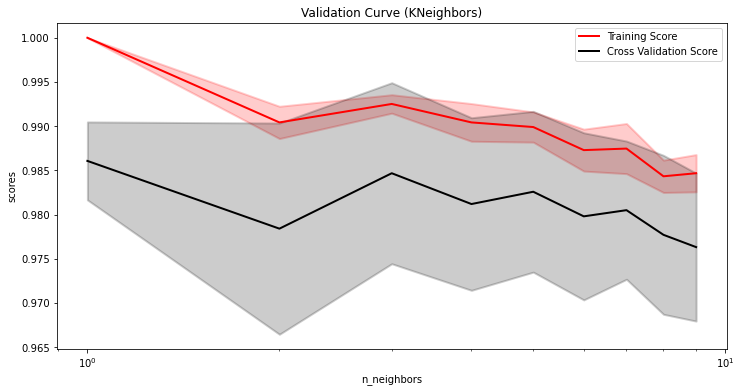

In [51]:
parameters = np.arange(1,10)
train_scores, test_scores = validation_curve(model,
                                             X_train,
                                             y_train,
                                             param_name = 'n_neighbors',
                                             param_range = parameters,
                                             scoring = 'accuracy',
                                             n_jobs = -1)
train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
test_scores_std = np.std(test_scores, axis = 1)
plt.figure(figsize=(12,6))
plt.title('Validation Curve (KNeighbors)')
plt.xlabel('n_neighbors')
plt.ylabel('scores')
plt.semilogx(parameters,
             train_scores_mean,
             label = 'Training Score',
             color = 'red',
             lw =2)
plt.fill_between(parameters,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha = 0.2,
                 color = 'red',
                 lw = 2)
plt.semilogx(parameters,
             test_scores_mean,
             label = 'Cross Validation Score',
             color = 'black',
             lw =2)
plt.fill_between(parameters,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha = 0.2,
                 color = 'black',
                 lw = 2)
plt.legend(loc = 'best')
plt.show()

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [1]:
from sklearn.model_selection import learning_curve

In [39]:
train_sizes, train_scores, test_scores = learning_curve(
                        estimator=model,
                        X=X_train,
                        y=y_train, 
                        train_sizes=np.linspace(0.1, 1.0, 20),
                        cv=10,
                        n_jobs=-1
                        )

# calculo de metricas
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [40]:
for k in range(len(train_sizes)):
    print('Tamaño Conjunto {}: {}'.format(k+1,train_sizes[k]))

Tamaño Conjunto 1: 145
Tamaño Conjunto 2: 214
Tamaño Conjunto 3: 283
Tamaño Conjunto 4: 352
Tamaño Conjunto 5: 421
Tamaño Conjunto 6: 490
Tamaño Conjunto 7: 559
Tamaño Conjunto 8: 628
Tamaño Conjunto 9: 697
Tamaño Conjunto 10: 766
Tamaño Conjunto 11: 835
Tamaño Conjunto 12: 904
Tamaño Conjunto 13: 973
Tamaño Conjunto 14: 1042
Tamaño Conjunto 15: 1111
Tamaño Conjunto 16: 1180
Tamaño Conjunto 17: 1249
Tamaño Conjunto 18: 1318
Tamaño Conjunto 19: 1387
Tamaño Conjunto 20: 1456


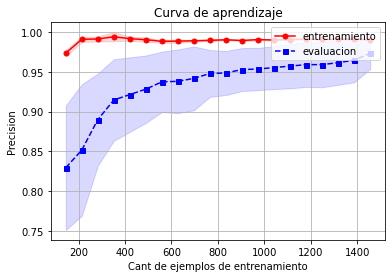

In [42]:
plt.plot(train_sizes, train_mean, color='r', marker='o', markersize=5,
         label='entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, color='r')
plt.plot(train_sizes, test_mean, color='b', linestyle='--', 
         marker='s', markersize=5, label='evaluacion')
plt.fill_between(train_sizes, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, color='b')
plt.grid()
plt.title('Curva de aprendizaje')
plt.legend(loc='upper right')
plt.xlabel('Cant de ejemplos de entrenamiento')
plt.ylabel('Precision')
plt.show()

## Extracción de atributos

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [123]:
x = StandardScaler().fit_transform(X)

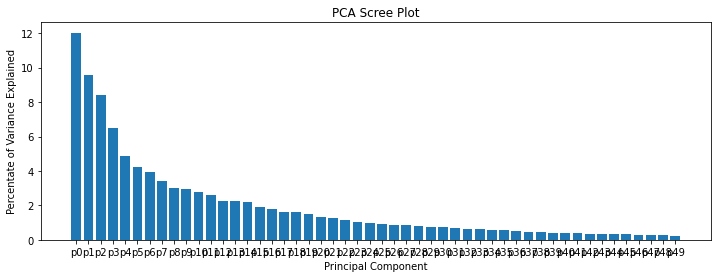

In [127]:
n_components = 50
pca = PCA(n_components)
principalComponents = pca.fit_transform(x)

# graficar varianza por componente
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = [ 'p'+str(i) for i in range(n_components)]

plt.figure(figsize=(12,4))
plt.bar(x= range(0,n_components), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

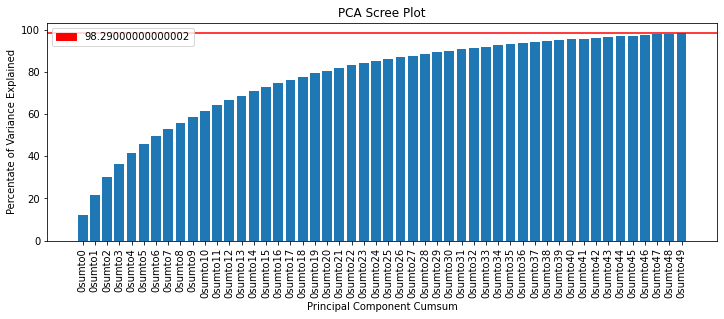

In [128]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label= str(percent_variance_cum[-1]) )


percent_variance_cum = np.cumsum(percent_variance)
columns = [ '0sumto'+str(i) for i in range(n_components) ]

plt.figure(figsize=(12,4))
plt.bar(x= range(0,n_components), height=percent_variance_cum, tick_label=columns)
plt.axhline(y=percent_variance_cum[-1], color='r', linestyle='-',label= str(percent_variance_cum[-1]))
plt.legend(handles=[red_patch])
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.show()

Del gráfico anterior se puede inferir que el $95\%$ de la varianza se puede explicar con n_components $=40$ y $98.2\%$ se puede explicar con $50$ componentes.

### Selección de atributos

Suponiendo que nos basta con el $95\%$ de la varianza, buscamos aquellas 40 componentes utilizando el algoritmo SelectKBest con prueba de Chi cuadrado para escoger las mejores 40 componentes.

In [117]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [129]:
df = pd.DataFrame(X)
df.columns = [f'P{k}' for k in range(1,X.shape[1]+1)]
df['y']=y
df.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P56,P57,P58,P59,P60,P61,P62,P63,P64,y
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [130]:
x_training = df.drop(['y',], axis=1)
y_training = df['y']

# Aplicando el algoritmo univariante de prueba de Chi2
k = 40  # número de atributos a seleccionar
columnas = list(x_training.columns.values)
seleccionadas = SelectKBest(chi2, k=k).fit(x_training, y_training)

In [131]:
catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]
atributos

['P3',
 'P6',
 'P7',
 'P10',
 'P11',
 'P14',
 'P15',
 'P18',
 'P19',
 'P20',
 'P21',
 'P22',
 'P23',
 'P26',
 'P27',
 'P28',
 'P29',
 'P30',
 'P31',
 'P34',
 'P35',
 'P36',
 'P37',
 'P38',
 'P39',
 'P42',
 'P43',
 'P44',
 'P45',
 'P46',
 'P47',
 'P51',
 'P53',
 'P54',
 'P55',
 'P59',
 'P61',
 'P62',
 'P63',
 'P64']

¿Qué sucede si entrenamos un nuevo modelo K neighbors con las componentes seleccionadas?

In [137]:
x=df[atributos]
x_train,x_test,y_train,y_test =  train_test_split(x,y,test_size=0.2,random_state=42)

In [138]:
clf = neighbors.KNeighborsClassifier()
clf.fit(x_train,y_train)

KNeighborsClassifier()

In [139]:
print('Con los conjuntos de entrenamiento y prueba seleccionados, el modelo identifica:', sum(y_test==clf.predict(x_test)), 'números correctamente, de un total de:', len(y_test),'.')

Con los conjuntos de entrenamiento y prueba seleccionados, el modelo identifica: 355 números correctamente, de un total de: 360 .


In [141]:
df_metrics = summary_metrics( pd.DataFrame( { 'y':y_test,
                                              'yhat':clf.predict(x_test) } ) )
confusion_matrix(list(y_test),list(clf.predict(x_test)))

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 34,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 45,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  1,  1,  0,  0,  0, 38]], dtype=int64)

In [142]:
df_metrics

,accuracy,recall,precision,fscore
0,0.9861,0.9878,0.9879,0.9878


Se puede observar, que se obtienen los mismos score luego de haber hecho la reducción de dimensiones aplicando PCA y SelectKBest juntos.

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [55]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns = "target").values
    y = digits["target"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 
    model.fit(X_train, y_train) # ajustando el modelo
    y_pred = model.predict(X_test)

    # Mostrar los datos correctos
    if label == "correctos":
        mask = (y_pred == y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label == "incorrectos":
        mask = (y_pred != y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
    

    X_aux = X_test[mask]
    y_aux_true = y_test[mask]
    y_aux_pred = y_pred[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation = 'nearest', cmap = 'gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10, color = color)
            ax[i][j].text(7, 0, label_true, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10, color = 'blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

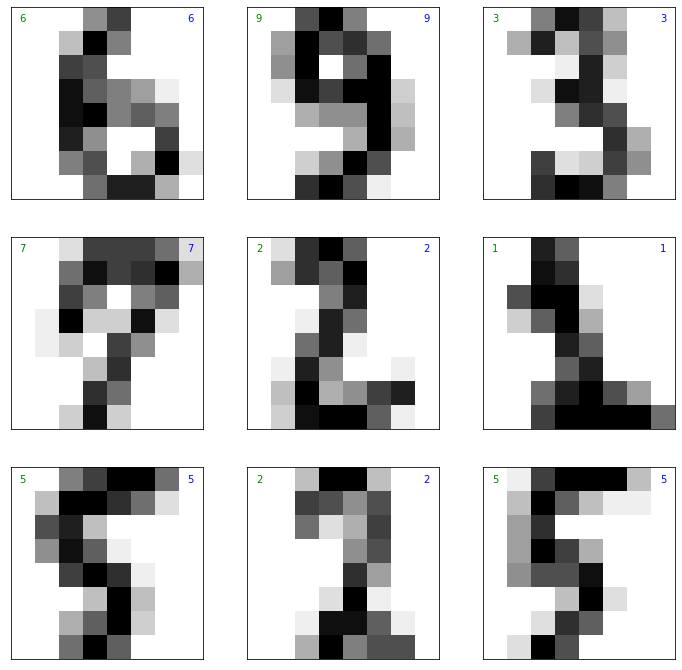

In [56]:
model=neighbors.KNeighborsClassifier()
mostar_resultados(digits,model,nx=3, ny=3,label = "correctos")

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.